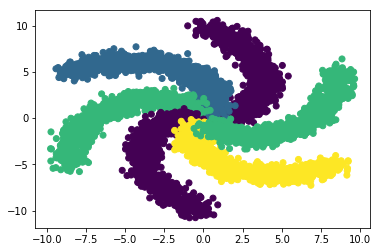

(5400, 2)

In [3]:
## Creating Data

import numpy as np
import matplotlib.pyplot as plt
def get_spiral():
    # Idea: radius -> low...high
    #           (don't start at 0, otherwise points will be "mushed" at origin)
    #       angle = low...high proportional to radius
    #               [0, 2pi/6, 4pi/6, ..., 10pi/6] --> [pi/2, pi/3 + pi/2, ..., ]
    # x = rcos(theta), y = rsin(theta) as usual

    radius = np.linspace(1, 10, 1000)
    thetas = np.empty((6, 1000))
    for i in range(6):
        start_angle = np.pi*i / 3.0
        end_angle = start_angle + np.pi / 2
        points = np.linspace(start_angle, end_angle, 1000)
        thetas[i] = points

    # convert into cartesian coordinates
    x1 = np.empty((6, 1000))
    x2 = np.empty((6, 1000))
    for i in range(6):
        x1[i] = radius * np.cos(thetas[i])
        x2[i] = radius * np.sin(thetas[i])

    # inputs
    X = np.empty((6000, 2))
    X[:,0] = x1.flatten()
    X[:,1] = x2.flatten()

    # add noise
    X += np.random.randn(6000, 2)*0.5

    # targets
    Y = np.array([0]*1000 + [1]*1000 + [2]*1000 + [0]*1000 + [3]*1000 + [2]*1000)
    return X, Y

X,y=get_spiral()

plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

## Processing the Data

def one_hot_encoder(X):
    N=X.shape[0]
    K=len(np.unique(X))
    Z=np.zeros((N,K))
    for i in range(N):
        c=int(X[i])
        Z[i,c]=1
    return Z
y_i=one_hot_encoder(y)

def standardize(X):
    stds=X.std(axis=0)
    means=X.mean(axis=0)
    X=(X-means)/stds
    return X,means,stds

X_s,m,s=standardize(X)

def train_test_split(X,y,size=0.8,rs=None):
    N=len(X)
    np.random.seed(rs)
    tr_i=np.random.choice(N,int(size*N),replace=False)
    t_i=[i for i in range(N) if i not in tr_i]
    X_train=X[tr_i]
    y_train=y[tr_i]
    X_test=X[t_i]
    y_test=y[t_i]
    return X_train,y_train,X_test,y_test
X_train,y_train,X_test,y_test=train_test_split(X_s,y,size=0.9,rs=20)

X_train=X_train.astype(np.float32)
y_train=y_train.astype(np.float32)
X_test=X_test.astype(np.float32)
y_test=y_test.astype(np.float32)

X_train.shape



In [4]:
import tensorflow as tf

class HiddenLayer(object):
    def __init__(self,i,M1,M2,af='relu',rs=None):
        self.id=i
        self.M1=M1
        self.M2=M2
        self.af=af
        
        self.W=tf.Variable(tf.random_normal(shape=[M1,M2],stddev=np.sqrt(M1),seed=rs,dtype=tf.float32))
        self.b=tf.Variable(tf.random_normal(shape=[M2],seed=rs,dtype=tf.float32))
        self.params=[self.W,self.b]
    def forward(self,X):
        if self.af=='tanh':
            return tf.nn.tanh(tf.matmul(X,self.W)+self.b)
        if self.af=='sigmoid':
            return tf.nn.sigmoid(tf.matmul(X,self.W)+self.b)
        if self.af=='relu':
            return tf.nn.relu(tf.matmul(X,self.W)+self.b)
        if self.af=='leaky-relu':
            return tf.nn.leaky_relu(tf.matmul(X,self.W)+self.b)

class ANN(object):
    def __init__(self,hidden_layer_size):
        self.hidden_layer_size=hidden_layer_size
        
    def forward(self,X):
        z=X
        for h in self.hidden_layers:
            z=h.forward(z)
        return tf.matmul(z,self.W)+self.b
    
    def predict(self,X):
        p=self.forward(X)
        return tf.argmax(p,axis=1)
    
    def fit(self,X,y,lr=0.001,epochs=1000,af=None,fig=True,batch_size=2900,n_batch=10,random_state=None):
        y=one_hot_encoder(y)
        if af==None:
            af=len(self.hidden_layer_size)*['relu']
        X_t,y_t,X_v,y_v=train_test_split(X,y,size=0.9,rs=random_state)
        c_t=[]
        c_v=[]
        cl_t=[]
        cl_v=[]
        N,D=X_t.shape
        self.hidden_layers=[]
        M1=D
        cnt=0
        for M2,a in zip(self.hidden_layer_size,af):
            h=HiddenLayer(cnt,M1,M2,a,random_state)
            self.hidden_layers.append(h)
            M1=M2
            cnt+=1
        M2=y.shape[1]
        self.W=tf.Variable(tf.random_normal([M1,M2],stddev=np.sqrt(M1),seed=random_state,dtype=tf.float32))
        self.b=tf.Variable(tf.random_normal(shape=[M2],seed=random_state,dtype=tf.float32))
        self.params=[self.W,self.b]
        for h in self.hidden_layers:
            self.params+=h.params
        tfX=tf.placeholder(tf.float32,shape=[None,D])
        tfY=tf.placeholder(tf.float32,shape=[None,M2])
        y_p=self.forward(tfX)
        cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_p,labels=tfY))
        preds=self.predict(tfX)
        optimizer=tf.train.RMSPropOptimizer(lr)
        train=optimizer.minimize(cost)
        with tf.Session() as s:
            s.run(tf.global_variables_initializer())
            for i in range(epochs):
                for j in range(n_batch):
                    x=X_t[j*batch_size:(j*batch_size+batch_size)]
                    yb=y_t[j*batch_size:j*batch_size+batch_size]
                    c_t.append(s.run(cost,feed_dict={tfX:x,tfY:yb}))
                    c_v.append(s.run(cost,feed_dict={tfX:X_v,tfY:y_v}))
                    cl_t.append(np.mean(s.run(preds,feed_dict={tfX:x})==np.argmax(yb,axis=1)))               
                    cl_v.append(np.mean(s.run(preds,feed_dict={tfX:X_v})==np.argmax(y_v,axis=1)))    
                    s.run(train,feed_dict={tfX:x,tfY:yb})
#                 c_t.append(s.run(cost,feed_dict={tfX:X_t,tfY:y_t}))
#                 c_v.append(s.run(cost,feed_dict={tfX:X_v,tfY:y_v}))
#                 cl_t.append(np.mean(s.run(preds,feed_dict={tfX:X_t})==np.argmax(y_t,axis=1)))               
#                 cl_v.append(np.mean(s.run(preds,feed_dict={tfX:X_v})==np.argmax(y_v,axis=1)))    
#                 s.run(train,feed_dict={tfX:X_t,tfY:y_t})   
                if i%100==0:
                    print('Epoch {0} Train C: {1} Cl: {2} Test C: {3} Cl:{4}'.format(i,c_t[i],cl_t[i],c_v[i],cl_v[i]))
        if fig==True:
            plt.plot(c_t,label='Train Cost')
            plt.plot(c_v,label='Test Cost')
            plt.legend()
            plt.show()
            plt.plot(cl_t,label='Train Classification')
            plt.plot(cl_v,label='Test Classification')
            plt.legend()
            plt.show()

In [ ]:
a=ANN((10,20,30))
a.fit(X_train,y_train,lr=0.001,epochs=3000,batch_size=540,n_batch=10,af=['sigmoid','leaky-relu','relu'])